# Long Short Term Memory (LSTM) Model

## Libraries and data loading

In [1]:
import pandas as pd


path = "sequences_dataset.xlsx"
df_train = pd.read_excel(path, sheet_name="df_train")
df_val = pd.read_excel(path, sheet_name="df_val")
df_test = pd.read_excel(path, sheet_name="df_test")

## Split data

In [2]:
train_seq = df_train.drop(columns=["y"]).values
train_y = df_train["y"].values

val_seq = df_val.drop(columns=["y"]).values
val_y = df_val["y"].values

test_seq = df_test.drop(columns=["y"]).values
test_y = df_test["y"].values

print("Train:", train_seq.shape, " --- ", train_y.shape)
print("Val: ", train_seq.shape, " --- ", train_y.shape)
print("Test: ", train_seq.shape, " --- ", train_y.shape)


Train: (2044, 44)  ---  (2044,)
Val:  (2044, 44)  ---  (2044,)
Test:  (2044, 44)  ---  (2044,)


## Model creation

In [8]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
import tensorflow as tf

max_words = 4000
input_length = train_seq.shape[1]

def create_lstm_model(optimizer='adam', learning_rate=0.001,
                      embedding_dim=128, lstm_units=128,
                      dropout_rate=0.5, activation='relu'):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = RMSprop(learning_rate=learning_rate)


    model = Sequential([
        Input(shape=[input_length]),
        Embedding(input_dim=max_words, output_dim=embedding_dim,),
        LSTM(lstm_units),
        Dense(32),
        Activation(activation),
        Dropout(dropout_rate),
        Dense(1),
        Activation('sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )
    return model


The best hyperparameters for this model were obtained from https://papaslatinas.org/index.php/rev-alap/article/view/81. The research aims to improve sentiment analysis of customer feedback for business intelligence, addressing the limitations of traditional machine learning methods.

The research Implements deep learning models, specifically LSTM neural networks and Transformer architectures, to classify customer sentiment into positive, negative, and neutral categories.

They find that the best hyperparameter for their LSTM model were the following:

- Embedding dimension: 128
- LSTM units: 128
- Dropout rate: 0.5
- Learning rate: 0.001

In [9]:
model = create_lstm_model()
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 44, 128)        │       512,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,745 (2.47 MB)

 Trainable params: 647,745 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

## Finding the best hyperparameters

In [28]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Wrap sklearn
model_clf = KerasClassifier(model=create_lstm_model, verbose=0)

# Hyperparameters
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__learning_rate': [0.0005],
    'model__embedding_dim': [128],
    'model__lstm_units': [32, 64],
    'model__dropout_rate': [0.3, 0.5],
    'model__activation': ['relu', 'tanh'],
    'batch_size': [32],
    'epochs': [5, 10]
}

# GridSearchCV
grid = GridSearchCV(estimator=model_clf,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=3,
                    verbose=2)


# Training
grid_result = grid.fit(train_seq, train_y)

# Results :0
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Params: {grid_result.best_params_}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END batch_size=32, epochs=5, model__activation=relu, model__dropout_rate=0.3, model__embedding_dim=128, model__learning_rate=0.0005, model__lstm_units=32, model__optimizer=adam; total time=   4.8s
[CV] END batch_size=32, epochs=5, model__activation=relu, model__dropout_rate=0.3, model__embedding_dim=128, model__learning_rate=0.0005, model__lstm_units=32, model__optimizer=adam; total time=   5.8s
[CV] END batch_size=32, epochs=5, model__activation=relu, model__dropout_rate=0.3, model__embedding_dim=128, model__learning_rate=0.0005, model__lstm_units=32, model__optimizer=adam; total time=  12.1s
[CV] END batch_size=32, epochs=5, model__activation=relu, model__dropout_rate=0.3, model__embedding_dim=128, model__learning_rate=0.0005, model__lstm_units=32, model__optimizer=rmsprop; total time=  11.1s
[CV] END batch_size=32, epochs=5, model__activation=relu, model__dropout_rate=0.3, model__embedding_dim=128, model__learning_rat

## Evaluating best model

In [36]:
best_model = create_lstm_model(
    optimizer='rmsprop', learning_rate=0.0005,
    embedding_dim=128, lstm_units=32,
    dropout_rate=0.3, activation='tanh'
)

history = best_model.fit(
    train_seq,
    train_y,
    validation_data=(val_seq, val_y),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5372 - loss: 0.6901 - val_accuracy: 0.6758 - val_loss: 0.6835
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6698 - loss: 0.6667 - val_accuracy: 0.6712 - val_loss: 0.6314
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7745 - loss: 0.5731 - val_accuracy: 0.7534 - val_loss: 0.5255
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8405 - loss: 0.4205 - val_accuracy: 0.7717 - val_loss: 0.4840
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8870 - loss: 0.2936 - val_accuracy: 0.7945 - val_loss: 0.4594
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9242 - loss: 0.2177 - val_accuracy: 0.7945 - val_loss: 0.4870
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9374 - loss: 0.1799 - val_accuracy: 0.7831 - val_loss: 0.5234
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9486 - loss: 0.1504 - val_accuracy: 0.7922 - v

In [37]:
test_loss, test_acc = best_model.evaluate(test_seq, test_y, verbose=0)
print(f"Test loss: {test_loss:.4f} — Test accuracy: {test_acc:.4f}")


Test loss: 0.6550 — Test accuracy: 0.7882


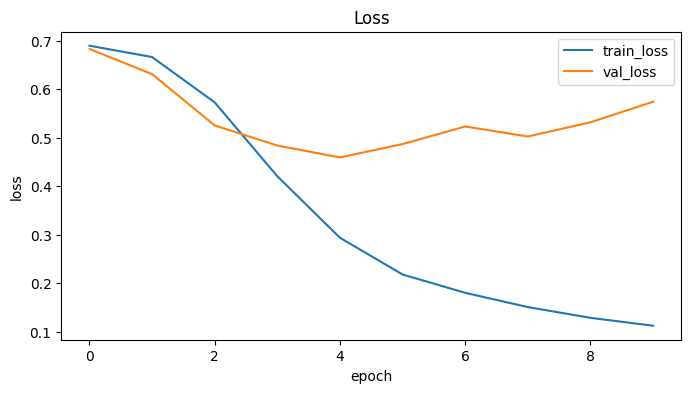

In [38]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss')
plt.show()

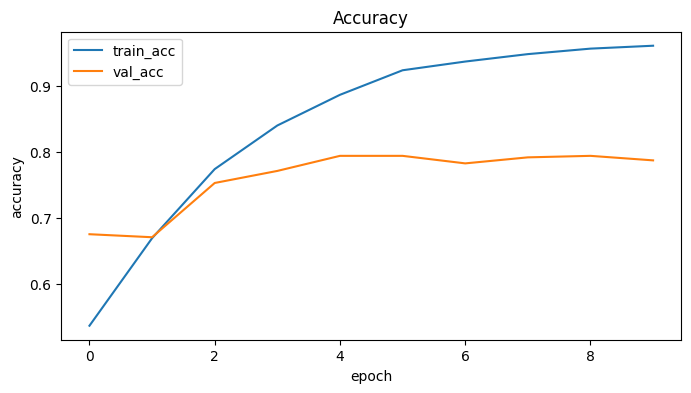

In [39]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
probs = best_model.predict(test_seq)
y_pred = (probs.ravel() >= 0.5).astype(int)



#Metrics
acc = accuracy_score(test_y, y_pred)
prec = precision_score(test_y, y_pred, zero_division=0)
rec = recall_score(test_y, y_pred, zero_division=0)
f1 = f1_score(test_y, y_pred, zero_division=0)
kappa = cohen_kappa_score(test_y, y_pred)

print(f"Accuracy:    {acc:.4f}")
print(f"Precision:   {prec:.4f}")
print(f"Recall:      {rec:.4f}")
print(f"F1-score:    {f1:.4f}")
print(f"Cohen kappa: {kappa:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy:    0.7882
Precision:   0.8066
Recall:      0.7668
F1-score:    0.7862
Cohen kappa: 0.5765


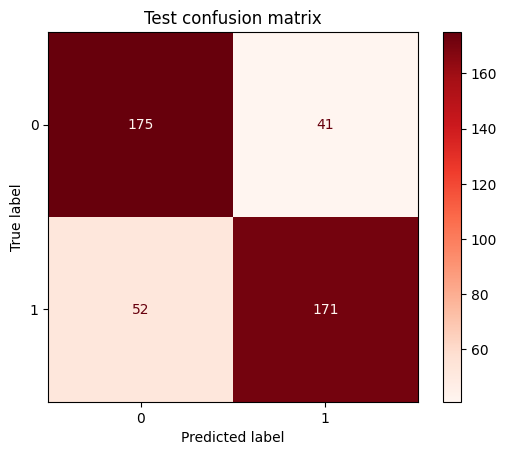

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_y, y_pred)
test_m = ConfusionMatrixDisplay(cm)
test_m.plot(cmap = "Reds")
plt.title("Test confusion matrix")
plt.show()




64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


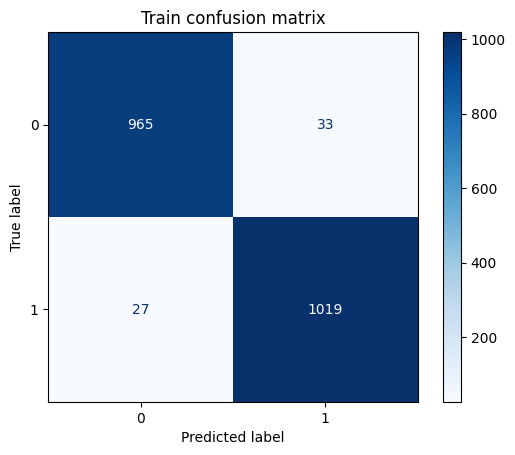

In [42]:
probs_train = best_model.predict(train_seq)
y_pred_train = (probs_train.ravel() >= 0.5).astype(int)

cm_train = confusion_matrix(train_y, y_pred_train)
test_m = ConfusionMatrixDisplay(cm_train)
test_m.plot(cmap = "Blues")
plt.title("Train confusion matrix")
plt.show()